# **Pokémon Diffusion<a id="top"></a>**

> #### **`00-Intro-And-Analysis.ipynb`**

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 14/06/2024</small></i></div>


¿Qué son los modelos de difusión? ¿Cómo funcionan? ¿Cómo se implementan? ¿Cómo se pueden utilizar para la síntesis de imágenes? Estas son algunas de las preguntas que se intentarán responder a lo largo de este proyecto.

Aquellas técnicas que se originan de métodos de estimación de probabilidad y toman inspiración de fenómenos físicos; se les llama **Modelos de Difusión**. La idea central detrás de los Modelos de Difusión proviene de la termodinámica, más en concreto de la entropía. Como una gota de tinta en vaso de agua que conforme pasa el tiempo se va difuminando hasta que el agua se vuelve de un color uniforme. En teoría de la información, esto equivale a la pérdida de información debido a la intervención gradual del ruido.

Los Modelos de Difusión se basan en aprender la descomposición sistemática de la información debido al ruido, y luego, revertir dicho proceso para recuperar la información, dando como resultado imágenes nuevas. Este concepto es similar a los VAEs en la forma en que intenta optimizar una función objetiva proyectando primero los datos en el espacio latente y luego, recuperándolos al estado inicial. Sin embargo, en lugar de aprender la distribución de los datos, el sistema tiene como objetivo modelar una serie de distribuciones de ruido en una Cadena de Markov y "decodifica" los datos deshaciendo/"desruidizando" los datos de manera jerárquica. Más adelante se verá con más detalle el funcionamiento de estos modelos.

<div style="text-align:center">
<img src='../figures/notebook_figures/charizard_diffusion_portada.jpg'>
</div>
</br>

> **Objetivo:**
>
> El objetivo de este proyecto, se basa en **modelos de difusión** desde un punto de vista exhaustivo y **práctico**, entendiendo su **funcionamiento**, **uso** e **implementación**. Para tratar de mostrar esto, se creará un modelo de difusión (DDPM) capaz de generar sprites de Pokémon de manera condicionada en función de su tipo. Para ello, se utilizará el dataset de imágenes de Pokémon: [Pokémon sprite images](https://www.kaggle.com/datasets/yehongjiang/pokemon-sprites-images) de Kaggle con licencia: <img src='https://licensebuttons.net/l/zero/1.0/80x15.png'>.
>
> <span style="color: red; font-size: 1.5em;">&#9888;</span> El proceso matemático de difusión se trata de un proceso aurduo y complejo. Por ello, en este notebook no se entrará tanto en detalle y en el informe de este proyecto se explicarán y se demostrarán más en profundidad los conceptos matemáticos de estos modelos de difusión.

Para cumplir con este objetivo podemos dividir este proyecto en varios notebooks:

- `00-Intro-And-Analysis.ipynb`: Introducción al proyecto y a los modelos de difusión junto con un análisis exploratorio del dataset. (Este notebook)

- `01-Dataset-Creation.ipynb`: Creación del dataset de imágenes de Pokémon.

- `02-Diffusion-Model-Architecture.ipynb`: Implementación de la arquitectura del modelo de difusión.

- `03-Diffusion-Process.ipynb`: Implementación y explicación del proceso de difusión.

- `04-Training-Diffusion-Model.ipynb`: Entrenamiento del modelo de difusión y la evaluación de dicho entrenamiento.
  
- `05-Evaluate-Diffusion-Samples.ipynb`: Evaluación de las muestras generadas tras el entrenamiento del modelo de difusión.

Dichos notebooks harán uso de los archivos de código `.py` que se encuentran en la carpeta `src` de este proyecto y que contienen las funciones necesarias para la implementación end-to-end de un modelo de difusión y que a lo largo de este notebook se irán explicando en detalle.

---

Este notebook se dividirá en las siguientes secciones:

- [0. Imports](#-0.-Imports)

- [1. Análisis del Dataset](#-1.-Análisis-del-Dataset)
  - [1.1. Dataset CSV](##-1.1.-Dataset-CSV)
  - [1.2. Dataset de Imágenes](##-1.2.-Dataset-de-Imágenes)


# 0. Imports

Una vez introducido el proyecto, se procederá a realizar un análisis exploratorio del dataset de imágenes de Pokémon. Para ello, se importan las librerías necesarias para el desarrollo de este apartado.

---


In [1]:
# Import necessary libraries
# =====================================================================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from src.data import path_loader as pl
from src.visualization import visualize
from src.utils import DATA_PATH

2024-06-14 16:23:02.990858: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-14 16:23:03.319297: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 16:23:04.937205: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-14 16:23:04.984101: I external/local_xla/x

# 1. Análisis del Dataset

En este apartado se explicará y realizará el proceso de carga y análisis del dataset de sprites de Pokémon, para su posterior procesamiento y uso en el modelo de difusión.

El [dataset descargado de Kaggle](https://www.kaggle.com/datasets/yehongjiang/pokemon-sprites-images) se compone de dos objetos:

- Una carpeta con las imágenes en archivos `.png` de los Pokémon.
- Un archivo `.csv` que contiene información sobre los Pokémon.

A continuación se explicará y procesará cada uno de estos elementos.

---


## 1.1. Dataset CSV

Cargamos el archivo `.csv` con la información de los Pokémon presentes en el dataset con el objetivo de obtener sus tipos para posteriormente poder asociarlos a las imágenes para el entrenamiento del modelo.


In [2]:
# Load the dataset
# =====================================================================
path = f"{DATA_PATH}/raw/pokedex.csv"
df = pd.read_csv(path, index_col="id", sep=",")

# Show df
df

,name,pokedex_id,type1,type2,primary_color,shape,legendary,mega_evolution,alolan_form,galarian_form,gigantamax,image_fn
id,,,,,,,,,,,,
0,Bulbasaur,1,Grass,Poison,Green,Quadruped,False,False,False,False,False,['1']
1,Ivysaur,2,Grass,Poison,Green,Quadruped,False,False,False,False,False,['2']
2,Venusaur,3,Grass,Poison,Green,Quadruped,False,False,False,False,False,['3']
3,Venusaur Gmax,3,Grass,Poison,Green,Quadruped,False,False,False,False,True,['3_g']
4,Venusaur Mega,3,Grass,Poison,Green,Quadruped,False,True,False,False,False,['3_2']
...,...,...,...,...,...,...,...,...,...,...,...,...
1113,Glastrier,896,Ice,NaN,White,Quadruped,True,False,False,False,False,['896']
1114,Spectrier,897,Ghost,NaN,Black,Quadruped,True,False,False,False,False,['897']
1115,Calyrex,898,Psychic,Grass,Green,Humanoid,True,False,False,False,False,['898_1']


Puesto que el objetivo de este proyecto es la creación de un modelo de difusión condicionado a los tipos de Pokémon, solo nos interesan las columnas que hagan referencia a los Pokémon en sí y a sus tipos. Por ello, nos quedamos solo con las columnas `id`, `name`, `pokedex_id`, `type1` y `image_fn` para poder después acceder a las imágenes y crear el conjunto de entrenamiento. Y, por tanto, descartamos el resto de columnas y en el caso de `type2` que es el tipo secundario de los Pokémon, se descartará con el objetivo de simplificar el problema de condicionamiento.

Por tanto, el dataframe resultante se compone de las siguientes columnas:

- `id`: Identificador del Pokémon.
- `name`: Nombre del Pokémon.
- `pokedex_id`: Número en la Pokédex del Pokémon.
- `type1`: Tipo principal del Pokémon.
- `image_fn`: Identificador del archivo de la imagen del Pokémon. Por ejemplo: `Bulbasaur` tiene como valor ['1'] y su primera imagen se encuentra en `DiffusionScratch/dataset/sprites/images/0000-Bulbasaur-1/front/normal/1-gen3_e-frame2.png`.

In [3]:
# Use only the necessary columns
# =====================================================================
df_processed = df.loc[:, ["name", "pokedex_id", "type1", "image_fn"]]

# Save the dataset
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df_processed.to_csv(path, sep=",", index=False)

# Show df
df_processed.head()

,name,pokedex_id,type1,image_fn
id,,,,
0,Bulbasaur,1,Grass,['1']
1,Ivysaur,2,Grass,['2']
2,Venusaur,3,Grass,['3']
3,Venusaur Gmax,3,Grass,['3_g']
4,Venusaur Mega,3,Grass,['3_2']


- ### Estudio de tipos

Como se ha comentado con anterioridad, usaremos el tipo principal de cada Pokémon para poder hacer un modelo de difusión condicionado. A continuación, visualicemos cuántos tipos distintos hay en el dataset y cuántos Pokémon hay de cada tipo.


- Number of types: 18 
- Types: ['Water', 'Normal', 'Grass', 'Bug', 'Psychic', 'Electric', 'Rock', 'Fire', 'Dark', 'Ghost', 'Fighting', 'Poison', 'Dragon', 'Ground', 'Steel', 'Ice', 'Fairy', 'Flying']


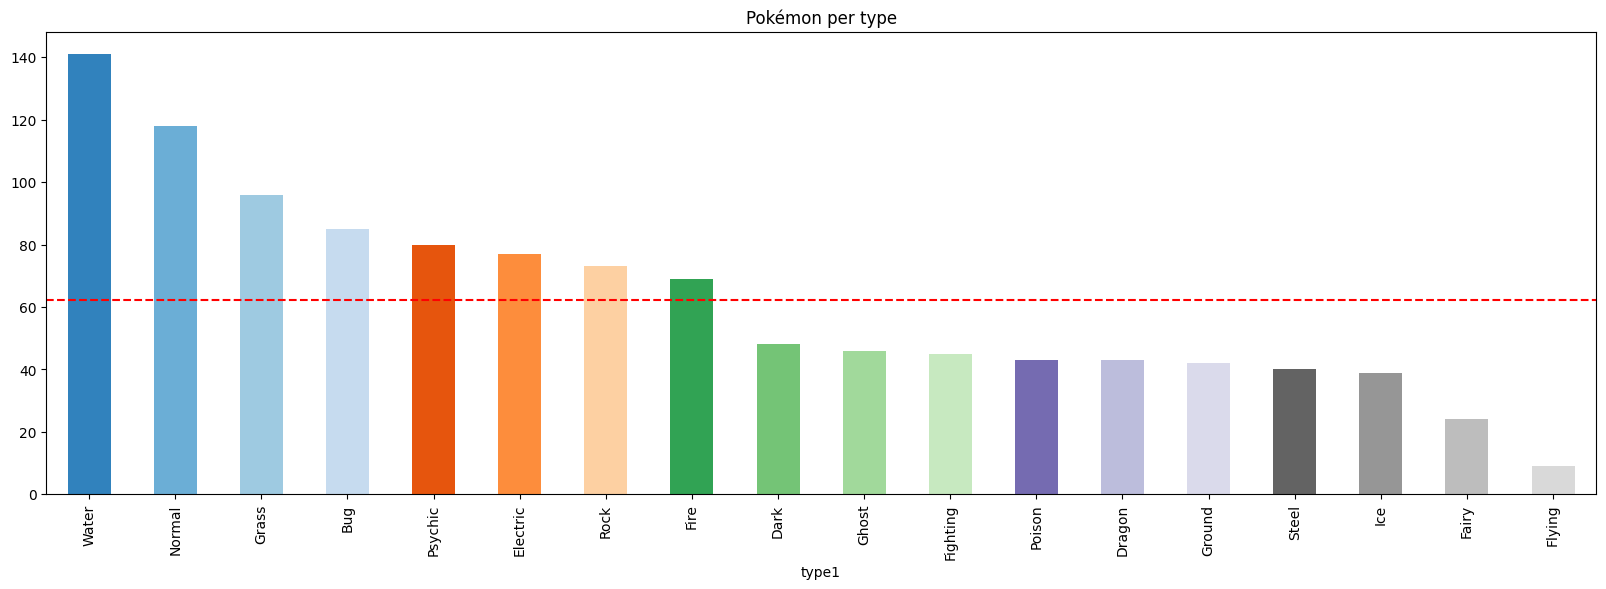

In [5]:
# Types study
# =====================================================================
types_series = df["type1"].value_counts()
print(
    f"- Number of types: {len(types_series)} \n- Types: {types_series.index.to_list()}"
)

# Plot the number of Pokémon per type
color_plot = plt.cm.tab20c(np.linspace(0, 1, len(types_series)))  # Color palette
types_series.plot(
    kind="bar", figsize=(20, 6), color=color_plot, title="Pokémon per type"
)

plt.axhline(y=types_series.mean(), color="r", linestyle="--")
plt.show()

Tras la visualización de los tipos, podemos encontrar que hay 18 tipos distintos de Pokémon en el dataset, siendo el tipo `Water` el más común y el `Fying` el menos común. Esta diferencia en la cantidad de Pokémon por tipo puede ser un problema a la hora de entrenar el modelo, ya que si hay un tipo con muy pocos Pokémon, el modelo no podrá aprender bien las características de dicho tipo.

A pesar de esto, no se realizará ningún tipo de balanceo de clases con el objetivo de también poder ver y estudiar cómo se comporta el modelo con este desbalance. Pues en teoría el modelo debería de ser capaz de aprender las características de cada tipo de Pokémon a pesar del desbalance.

## 1.2. Dataset de Imágenes

Una vez cargado y procesado los datos de interés, cargamos las imágenes de Pokémon que usaremos para entrenar al modelo de difusión. Pues el dataset contiene imágenes de Pokémon de distintas formas (frente, espalda, shiny, etc). Por ello, nos quedaremos solo con las imágenes de frente normales de los Pokémon, pues a la hora de la síntesis de imágenes, las imágenes de frente son las que tienen más sentido y son más representativas. También se descartan las imágenes shiny (variante de color de un Pokémon), puesto que harán que el modelo no consiga generalizar bien a la hora del condicionado del modelo, ya que existen la misma cantidad de imágenes shiny que normales.

Para conseguir esto, nos apoyaremos en la clase `PathLoader()` que permite cargar las imágenes de los Pokémon seleccionando solo las imágenes deseadas. Esto lo hace obteniendo los path de las imágenes de los Pokémon de interés y almacenándolos en un fichero `.json` para su posterior uso. Además, si el fichero `.json` ya existe, se cargará directamente el fichero en lugar de volver a extraer los paths de las imágenes. Esto nos ayudará ahorrar tiempo de ejecución en caso de que queramos hacer pruebas intermedias y/o volver a ejecutar el notebook.

> <span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**Nota:** La elección de tratar las imágenes como el path de la imagen y no como la imagen en sí, es debido a que así el proceso de preparación de los datos y del modelo es más rápido y eficiente ya que así solo guardaremos las imágenes que nos interesan una vez ya preprocesadas.
> </small></i>

In [6]:
# Creates the image paths list and saves it to a file
# =====================================================================
loader = pl.PathLoader(
    load_pattern=f"{DATA_PATH}/raw/sprites/**/front/normal/*.png",
    save_file=Path(f"{DATA_PATH}/interim/image_paths.json"),
)

# Load the paths from the file
image_paths = loader.load_paths(save=True)

2024-06-14 16:24:11,630 - INFO - 4086 paths loaded from /workspaces/tf-diffusion-scratch/data/interim/image_paths.json
2024-06-14 16:24:11,631 - INFO - Using existing paths from /workspaces/tf-diffusion-scratch/data/interim/image_paths.json


- Después de cargar los paths de los Pokémon deseados, podemos visualizar una muestra de ellos para ver que todo está correcto y sacar conclusiones del preprocesado posterior que tendremos que hacer a las imágenes.

  Esta visualización se hace gracias a la función `plot_image_paths()` que permite visualizar un número determinado de imágenes de Pokémon de forma aleatoria a través de los paths de las imágenes.

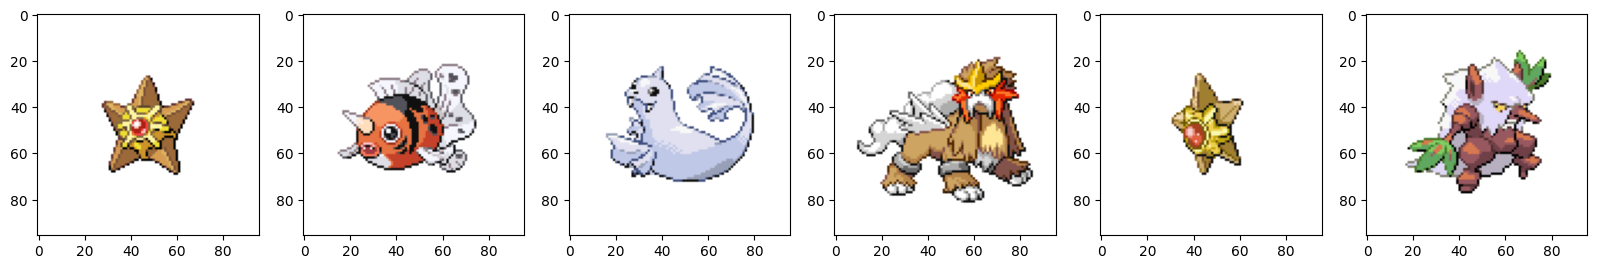

In [9]:
# plot random images
# =====================================================================
visualize.plot_image_paths(image_paths=image_paths, n=6)

- Una vez terminado el proceso de carga de las imágenes y su visualización, se pueden sacar las siguientes conclusiones:

  - Las imágenes de los Pokémon tienen un tamaño de 96x96 píxeles.
  - Las imágenes de los Pokémon tienen un fondo blanco que no aporta nada al modelo. Y aumenta la dimensionalidad de las imágenes.

  Por tanto, se puede observar que las imágenes de los Pokémon necesitan un preprocesado antes de ser usadas en el modelo de difusión. Por ello, en primera instancia, en la parte de preprocesado de los datos, se realizará un recorte del fondo de las imágenes. Con esto, se eliminará el ruido y se centrará la atención del modelo en el Pokémon en sí.

  En este punto tenemos toda la información necesaria para poder crear el dataset de entrenamiento del modelo de difusión. Pues, por un lado, tenemos la información de los Pokémon y, por otro lado, tenemos las imágenes de los Pokémon. Aunque estas últimas sean en path para ahorrar tiempo de ejecución en este preprocesado.


[BACK TO TOP](#top)
